In [67]:
import pandas as pd

In [35]:

#Change in a row from prior record
original = pandas.read_csv(f"data-sources/row-change.csv", header=0)
display(original)
changed = pandas.read_csv(f"data-sources/row-change-diff.csv")
display(changed)
compared = original.compare(changed, keep_shape=True)
compared.columns = compared.columns.get_level_values(0)
new = compared.loc[:,~compared.columns.duplicated(keep='last')]
print("Record Changed")
display(new)



,id,species,species_count
0,1,salmon,1


,id,species,species_count
0,1,salmon,2


Record Changed


,id,species,species_count
0,NaN,NaN,2


In [55]:
#delete record
original = pandas.read_csv(f"data-sources/row-delete.csv", header=0)
display(original)
changed = pandas.read_csv(f"data-sources/row-delete-diff.csv")
display(changed)
compared = changed.reindex_like(original).compare(original)
compared.columns = compared.columns.get_level_values(0)
new = compared.loc[:,~compared.columns.duplicated(keep='last')]
print('Record Deleted')
display(new)



,id,species,species_count
0,1,salmon,1
1,2,salmon,5


,id,species,species_count
0,1,salmon,1


Record Deleted


,id,species,species_count
1,2.0,salmon,5.0


In [49]:
#add record
original = pandas.read_csv(f"data-sources/row-add.csv", header=0)
display(original)
changed = pandas.read_csv(f"data-sources/row-add-diff.csv")
display(changed)
new = changed[ ~changed.id.isin(original.id)].dropna()
display(new)



,id,species,species_count
0,1,salmon,1


,id,species,species_count
0,1,salmon,1
1,2,pollock,2


,id,species,species_count
1,2,pollock,2


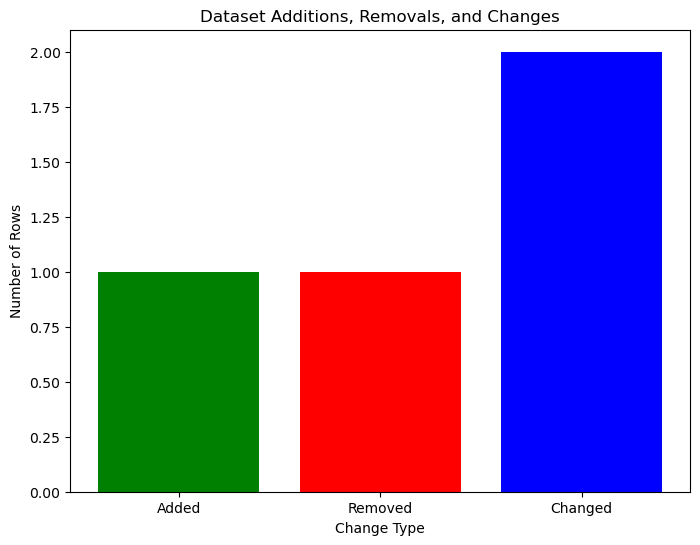

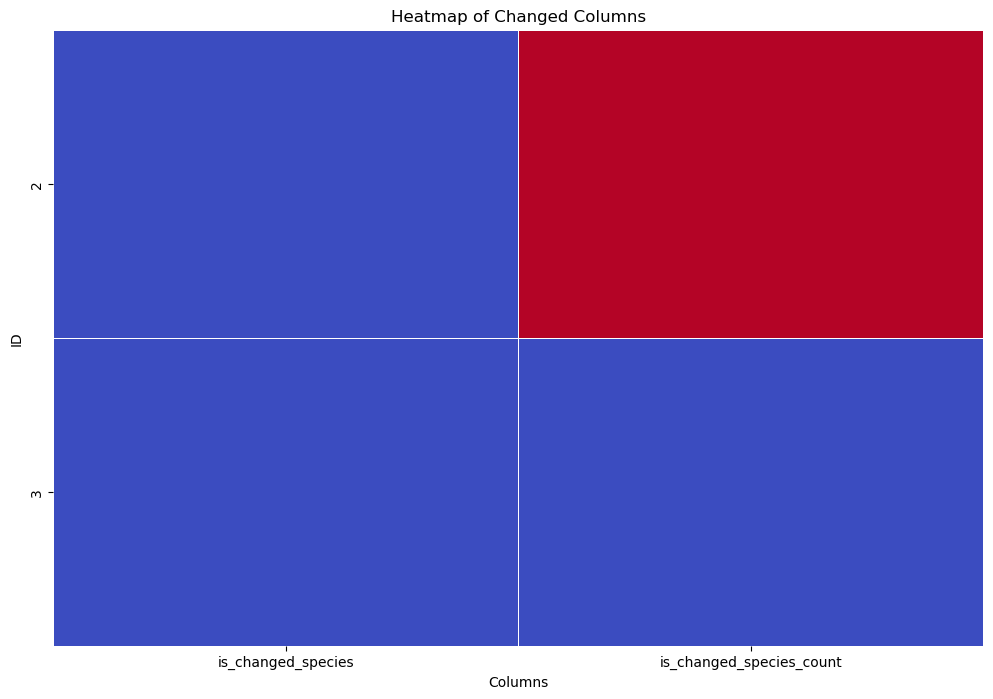

Rows Added:


,id,species_old,species_count_old,species_new,species_count_new,_merge
0,4,NaN,NaN,salmon,4.0,right_only


Rows Removed:


,id,species_old,species_count_old,species_new,species_count_new,_merge
0,1,salmon,1.0,NaN,NaN,left_only


ID: 2 - Changed Columns: ['species_count']


id                     2
species_count_old    5.0
species_count_new    6.0
Name: 0, dtype: object

Summary of Changes for each Column:


,Column,Number of Changes
1,is_changed_species_count,1
0,is_changed_species,0


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Example: Loading two CSV files into DataFrames
df_old = pandas.read_csv('data-sources/row-all-operations.csv')
df_new = pandas.read_csv('data-sources/row-all-operations-diff.csv')

# Step 2: Identify Added, Removed, and Changed Rows

# Merge on unique identifier (e.g., 'id')
merged = df_old.merge(df_new, on='id', how='outer', suffixes=('_old', '_new'), indicator=True)

# Identify added, removed, and potentially changed rows
added_rows = merged[merged['_merge'] == 'right_only'].copy()  # Create a copy
removed_rows = merged[merged['_merge'] == 'left_only'].copy()  # Create a copy
changed_rows = merged[merged['_merge'] == 'both'].copy()  # Create a copy

# Reset index to avoid chained assignment issues
added_rows = added_rows.reset_index(drop=True)
removed_rows = removed_rows.reset_index(drop=True)
changed_rows = changed_rows.reset_index(drop=True)

# Step 3: Identify Changed Columns in Changed Rows

# List of columns to compare (excluding 'id')
columns_to_compare = df_old.columns.difference(['id'])

# Iterate over each column to compare
for column in columns_to_compare:
    old_col = column + '_old'
    new_col = column + '_new'
    # Create a boolean column to indicate if the value changed using .loc
    changed_rows.loc[:, 'is_changed_' + column] = changed_rows[old_col] != changed_rows[new_col]

# Step 4: Visualize Added, Removed, and Changed Rows

# Visualization of Added, Removed, and Changed Rows with a Bar Chart
# Bar chart showing added, removed, and changed rows
change_summary = pd.DataFrame({
    'Change Type': ['Added', 'Removed', 'Changed'],
    'Count': [len(added_rows), len(removed_rows), len(changed_rows)]
})

plt.figure(figsize=(8, 6))
plt.bar(change_summary['Change Type'], change_summary['Count'], color=['green', 'red', 'blue'])
plt.xlabel('Change Type')
plt.ylabel('Number of Rows')
plt.title('Dataset Additions, Removals, and Changes')
plt.show()

# Visualization of Changed Columns with a Heatmap

# Create a matrix to visualize the changes (1 if changed, 0 if not)
change_matrix = changed_rows.set_index('id')[['is_changed_' + col for col in columns_to_compare]].astype(int)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(change_matrix, cmap="coolwarm", cbar=False, linewidths=0.5)
plt.title('Heatmap of Changed Columns')
plt.xlabel('Columns')
plt.ylabel('ID')
plt.show()

# Step 5: Display Detailed Changes for Added, Removed, and Changed Rows

# Display Added Rows
print("Rows Added:")
display(added_rows)

# Display Removed Rows
print("Rows Removed:")
display(removed_rows)

# Display Changed Rows with Detailed Column Changes
# Display the detailed changes for each row
for index, row in changed_rows.iterrows():
    changed_columns = [col for col in columns_to_compare if row['is_changed_' + col]]
    if changed_columns:
        print(f"ID: {row['id']} - Changed Columns: {changed_columns}")
        display(row[["id"] + [col + '_old' for col in changed_columns] + [col + '_new' for col in changed_columns]])

# Summary of Changes for each Column

# Summary of how many times each column was changed
change_summary = change_matrix.sum().reset_index()
change_summary.columns = ['Column', 'Number of Changes']
change_summary = change_summary.sort_values(by='Number of Changes', ascending=False)

# Display the summary
print("Summary of Changes for each Column:")
display(change_summary)